### Consider a different scalar PDE: Convection-Diffusion equations [Mika Meyer, Kolja Straatman, Pascal Irmer]

Consider the (reaction-)convection-diffusion equation
$$
-\nabla \cdot (\alpha \nabla u) + \beta \cdot \nabla u + \gamma u = f
$$
in $\Omega$, equipped with suitable boundary conditions.

Implement a FEM solver for this problem and carry out numerical experiments to investigate the influence of the convection term on the solution.

Consider the following standard test problem: 
 * Set $ \gamma = 0$, and $\beta = (1,1)$, $\Omega = (0,1)^2$
 * Use homogeneous Dirichlet boundary conditions: $u|_{\partial \Omega} = 0$, see [Dirichlet demo notebook](../demos/dirichlet_2D.ipynb).
 * Consider the so-called mesh Péclét number $Pe = \frac{2 \| \beta \|_\infty}{\gamma h}$, where $h$ is the (initially uniform) mesh size.
 * Take the details as in [this paper, page 19 ff.](https://www.asc.tuwien.ac.at/~schoeberl/wiki/publications/MixedHybridDG.pdf), i.e. take the exact solution and compute (verify) the corresponding r.h.s. and compute the numerical solutions.
 * Implement the (missing) convection integral for $\int_\Omega \beta \cdot \nabla u v \, dx $ in the bilinear form (including tests and notebook(s))
 * Do numerical studies over $h$ and/or $Pe$ with different FE spaces
 * Document the results in proper notebook(s)
 * Use strechted grids (by introducing a mapping in the construction of the mesh) with increasingly small elements towards $x=1$ and $y=1$ and investigate the influence on the solution. (including documentation in notebook(s))


Weak Formulation: $$\int_\Omega \alpha \nabla u \nabla v dx + \int_\Omega  \beta \nabla u v dx +\int_\Omega \gamma u v dx=\int_\Omega fv dx + \int_{\partial\Omega} \alpha \nabla u v ds$$

source module for methodsNM imported.


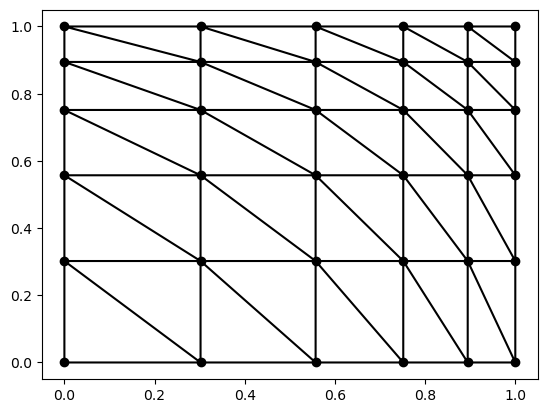

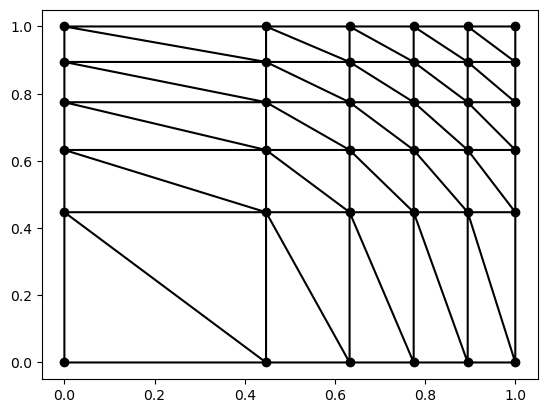

In [1]:
import import_hack
from methodsnm.mesh_2d import *
from methodsnm.visualize import *
from numpy import pi, cos, sin, arctan, tanh, tan
N=5
mesh = StructuredRectangleMesh(N, N)
mesh_mod2 = StructuredRectangleMesh(N, N,mapping= lambda x,y: (x**0.5, y**0.5))
mesh_mod = StructuredRectangleMesh(N, N, mapping= lambda x,y: (arctan(tan(1)*x), arctan(tan(1)*y)))
h =1/N
DrawMesh2D(mesh_mod)
DrawMesh2D(mesh_mod2)

In [2]:
from methodsnm.fes import *
fes = P3_Triangle_Space(mesh_mod)

In [3]:
from methodsnm.forms import *
from methodsnm.formint import *

beta = np.array([0,0])
alpha = 0.1
gamma = 0
blf = BilinearForm(fes)
c = GlobalFunction(lambda x: alpha, mesh = mesh_mod)
blf += LaplaceIntegral_Lehrenfeld(c)
blf += ConvectionIntegral(beta=beta)
blf.assemble()

lf = LinearForm(fes)

conv_diff = lambda x, alpha, beta, gamma: \
    beta[0]*(x[1] + (np.e**(beta[1]*x[1]/alpha) - 1)/
             (1 - np.e**(beta[1]/alpha))) + \
    beta[1]*(x[0] + (np.e**(beta[0]*x[0]/alpha) - 1) /
             (1 - np.e**(beta[0]/alpha)))
f = GlobalFunction(lambda x: conv_diff(x, alpha, beta, gamma), mesh = mesh_mod)
f1 = GlobalFunction(lambda x: 1, mesh = mesh_mod)


lf += SourceIntegral(f1)
lf.assemble()                                                                                             

In [4]:
u_exact = GlobalFunction(lambda x: (x[0]+(np.exp(beta[0]*x[0]/alpha)-1)/(1-np.exp(beta[0]/alpha)))*(x[1]+(np.exp(beta[1]*x[1]/alpha)-1)/(1-np.exp(beta[1]/alpha))), mesh=mesh)
#DrawFunction2D(u_exact)
#DrawFunction2D(u_exact, contour=True) 

In [5]:
#plt.spy(blf.matrix, markersize=4*h)

In [6]:
dirichlet_mask = np.zeros(fes.ndof,dtype=bool)
for belnr, verts in enumerate(mesh.elements(bndry=True)):
    dirichlet_mask[fes.element_dofs(belnr, bndry=True)]=True
non_dirichlet_mask = np.logical_not(dirichlet_mask)
#print(non_dirichlet_mask)    

In [7]:
A = blf.matrix[non_dirichlet_mask,:][:,non_dirichlet_mask]
b = lf.vector[non_dirichlet_mask]
#print(blf.matrix.shape, " -> ", A.shape)
uh = FEFunction(fes)
from scipy.sparse.linalg import spsolve

uh.vector[non_dirichlet_mask] = spsolve(A, b)

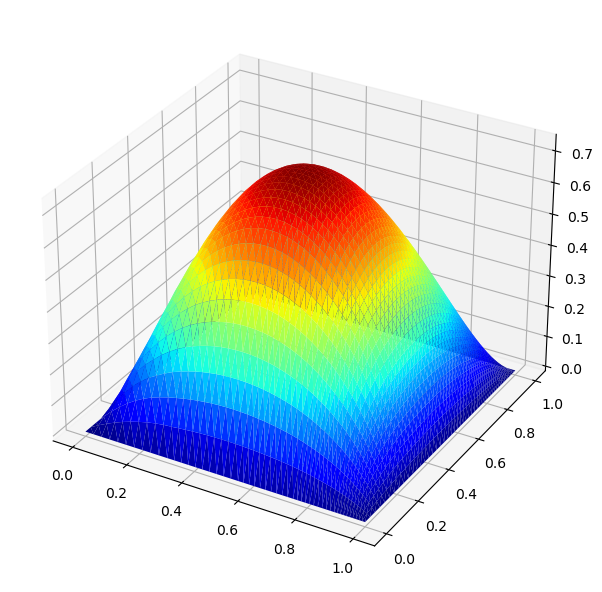

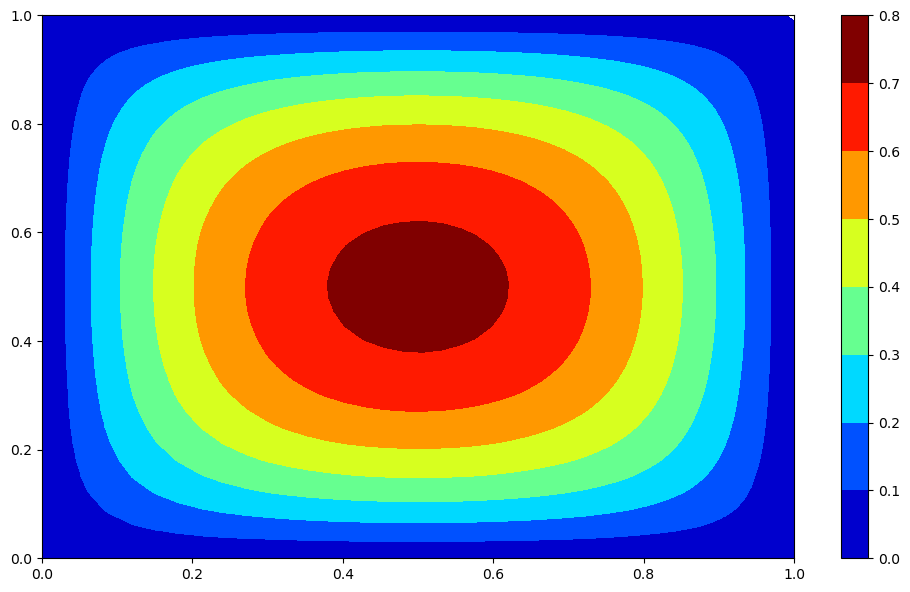

In [8]:
DrawFunction2D(uh, contour=False)
DrawFunction2D(uh, contour=True)

In [9]:
e=error_calc(uh, u_exact)
beta_max = beta.flat[np.abs(beta).argmax()]
Pec = beta_max /(alpha*h)
print("Péclét number:", Pec)
print(e)

Péclét number: 0.0
nan


/tmp/ipykernel_1262/695392708.py:1: RuntimeWarning: invalid value encountered in double_scalars
  u_exact = GlobalFunction(lambda x: (x[0]+(np.exp(beta[0]*x[0]/alpha)-1)/(1-np.exp(beta[0]/alpha)))*(x[1]+(np.exp(beta[1]*x[1]/alpha)-1)/(1-np.exp(beta[1]/alpha))), mesh=mesh)


In [10]:
a=np.array([mesh,mesh_mod])
print(a)

In [11]:
import matplotlib.pyplot as plt
n=np.arange(5,11,2)
sol1=np.zeros(len(n))
sol2=np.zeros(len(n))
j=0
FE = np.array([P1_Triangle_FE, P2_Triangle_FE, P3_Triangle_FE])
for k in range(1):
    j=0
    for i in n:
        sol1[j] = NumericalStudies(i,beta,alpha,gamma,FE[k+2])[0]
        sol2[j] = NumericalStudies(i,beta,alpha,gamma,FE[k+2])[1]
        j += 1
    
    plt.plot(1/sol2, sol1, label= "...")
    plt.grid(True)
    #plt.legend(loc='lower left', prop={'size': 7.5})
    plt.xlabel('Mesh')
    plt.ylabel('Error')
    #plt.yscale("log")
    #plt.xscale("log")
    plt.show()

TypeError: P3_Triangle_FE.__init__() takes 1 positional argument but 2 were given